# Introduction to Support Vector Machines and KMeans clustering

This is an extremely brief introduction to 

- Support Vector Machines (Splitting datasets along a hyperplane -> Supervised Learning)
- KMeans clustering (Clustering datasets into similar groups -> Unsupervised Learning)

For both techniques, the well documented and usable implementations in scikit learn are used.

In [2]:
# Standard imports
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Scikit learn imports
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import datasets
# Other imports
import itertools
import plotly.offline as po

## Load DB open container dataset

Contains position and state data from containers in transport. Since this gives us data with label and x-y-position, we can use them for our first AI software!

In [3]:
# Load data
df = pd.read_csv('http://download-data.deutschebahn.com/static/datasets/sensordaten_schenker/161209_Schenker_Sensordaten.csv')
# First line contains comments
df.drop(0, inplace = True)
# inspect
df.head()

,index,SXXJ number,Container,Date,Time_UTC,Latitude,Longitude,Accuracy,Active,Reverse,...,Door,Mount,Motion,GForce,Tilt,Temperature,Humidity,Light,Origin,Destination
1,0,A,NONE,2016-08-08,14:39:36,NaN,NaN,NaN,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,A,NONE,2016-08-08,14:39:45,NaN,NaN,NaN,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,A,NONE,2016-08-08,14:40:34,25.794100,-80.369301,cellid,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,A,NONE,2016-08-08,15:57:46,NaN,NaN,NaN,1,0,...,0,0,0,0.000,NaN,29.800,75.700,NaN,NaN,NaN
5,4,A,NONE,2016-08-08,15:58:50,25.799700,-80.367302,cellid,1,0,...,0,0,0,0.000,NaN,29.900,73.000,NaN,NaN,NaN


This dataset is a good example for realworld datasets with missing data and string formatted numbers. So we proceed with data cleaning:

- Remove NaN
- Convert strings to numbers

The ```describe()``` method gives a good impression whether we succeeded.

In [4]:
df.dropna(subset=['Latitude', 'Longitude', 'Humidity', 'Temperature'], inplace = True)
df = df[['Latitude', 'Longitude', 'Humidity', 'Temperature']].apply(pd.to_numeric)
df.describe()

,Latitude,Longitude,Humidity,Temperature
count,2136.000000,2136.000000,2136.000000,2136.000000
mean,35.686900,49.061009,53.166526,7.801264
std,17.137498,86.569548,12.958645,16.846114
min,-12.107100,-179.957001,16.800000,-27.200000
25%,30.624100,0.163120,43.000000,-5.425000
50%,41.675800,101.989998,51.750000,6.900000
75%,49.603001,121.899500,63.925000,22.500000
max,57.122700,178.399002,83.800000,47.300000


### Further data inspection:

Scatter plot of position with 'Temperature'-coloured marker, no map background:

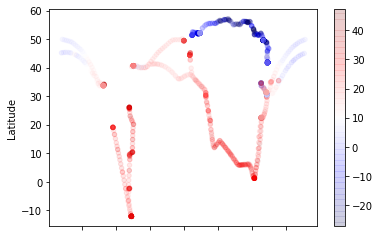

In [5]:
df.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', c = df['Temperature'], cmap = 'seismic', alpha = 0.1)

### Optional: Scatter plot on map background

In [6]:
data = [ dict(
        type = 'scattergeo',
        #locationmode = 'Germany',
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['Temperature'],
        mode = 'markers',
        marker = dict(
            size = 0.1*df['Humidity'],
            opacity = 0.8,
            #reversescale = True,
            autocolorscale = False,
            #symbol = 'square',
            colorscale = 'Jet',
            color = df['Temperature'],
            #cmax = df['Temperature'].max(),
            colorbar=dict(thickness=20)
        ))]

layout = dict(
        title = 'Observed container temperatures',
        colorbar = dict(),
        geo = dict(
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5,
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ df['Longitude'].min(), df['Longitude'].max() ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ df['Latitude'].min(), df['Latitude'].max() ],
                dtick = 5
            )
        ),
    )

fig = dict( data=data, layout=layout )
po.plot(fig, validate=False, filename='d3-container.html')

'd3-container.html'

## Primer on AI techniques

### Train SVM

Let's try to predict frost since this may ruin some goods. To achieve this, we need to:

- Split the dataset into training and test data

    - It is important to test on unseen data
    
- Scale data

    - Equally important to scale the data in order to normalise variance
    
- Fit SVM

For splitting the dataset, we can use the ```train_test_split``` function of scikit learn:

In [7]:
from sklearn.model_selection import train_test_split
# Data selection
X = df[['Latitude', 'Longitude']]
# Label target data (we need 2 classes!) 
y = (df['Temperature'] <0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42) # one third of the dataset

The scaler of choice is the standard scaler, which needs to be trained itself (which however can be done in one step with the transformation using ```fit_transform```):

In [8]:
# Initialise scaler
scaler = StandardScaler()
# Scale data
X_train_scale = scaler.fit_transform(X_train)

In order to train the SVM, we initialise it, in the case at hand with two parameters:

- C: the "penalty" of misclassifications,

    - lower C values provide smooth classifiers
    - higher C values provide more strict classification
    
- class_weight: in the data present, we have an unbalanced proportion of true (= frost) and false, so we can give more weight to true values

In [9]:
# Initialise support vector machine
svm_clf = SVC(C = 10, class_weight = {True: 10, False:1})
# Fit SVM
svm_clf.fit(X_train_scale, y_train)

SVC(C=10, class_weight={False: 1, True: 10})

### Plot decision surface of classifier

In order to print the decision surface of our classifier, we need to generate gridded data and plot these on the x-y-plane.

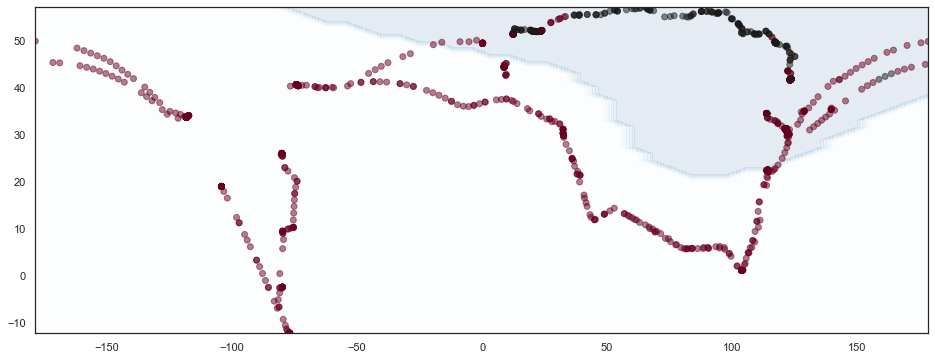

In [10]:
sns.set()
# Plot 3D scatter with decision boundary
from mpl_toolkits.mplot3d import Axes3D
x = X_train['Longitude']
y = X_train['Latitude']
c = y_train*1.0

xx = np.linspace(min(X_train_scale[:,0]), max(X_train_scale[:,0]), 50)
yy = np.linspace(min(X_train_scale[:,1]), max(X_train_scale[:,1]), 50)
[Y, X] = np.meshgrid(xx, yy)
Z = svm_clf.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)
xx = np.linspace(min(x), max(x), 50)
yy = np.linspace(min(y), max(y), 50)
[X, Y] = np.meshgrid(xx, yy)

with sns.axes_style('white'):
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(111)
    ax.contourf(X, Y, Z, cmap = 'Blues', alpha = 0.1)
    ax.scatter(x, y, c = c, cmap = 'RdGy', alpha = 0.5)

## Exercise: 

Try with different values of C and class_weight, observe the changing decision surface.

### Solution:

See above for C = 10

### Test on unseen data

As discussed above, we need to test whether the trained algorithm works on data not used for training.

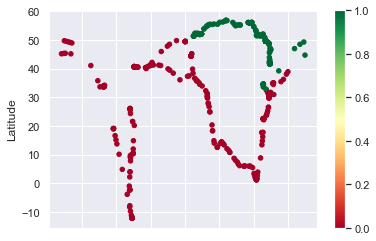

In [11]:
X_test_scale = scaler.transform(X_test)
# Predict 
y_pred = svm_clf.predict(X_test_scale)
# Plot
X_test.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', c=y_pred.astype(int), cmap = 'RdYlGn')

While the above plot appears to be credible, we should inspect confusion matrix:

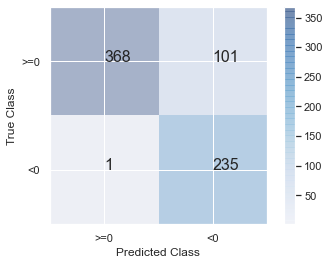

In [12]:
conf_mat = confusion_matrix(1.0*y_test, 1.0*y_pred)
plt.imshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
plt.colorbar()
plt.xticks((0, 1), (">=0", "<0"))
plt.yticks((0, 1), (">=0", "<0"))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
for i,j in itertools.product((0,1), (0,1)):
    plt.text(j,i, conf_mat[i,j], fontsize = 16)

## Exercise:

Repeat the SVM parameter variation and inspect the confusion matrix accordingly.

What are the dangerous cases?

### Solution

The dangerous case for most goods is predicting of no frost, while frost occurs. A $C$- value of 10 reduces the occurrences to 1. 

---

# KMeans clustering

As opposed to the supervised learning algorithm applied above, for clustering we do not need class labels. The algorithm infers the classification from structures in the data.

Let's give it a try and load some data, in the case at hand an iris flower dataset: https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset

Text(0.5, 1.0, 'Predicted')

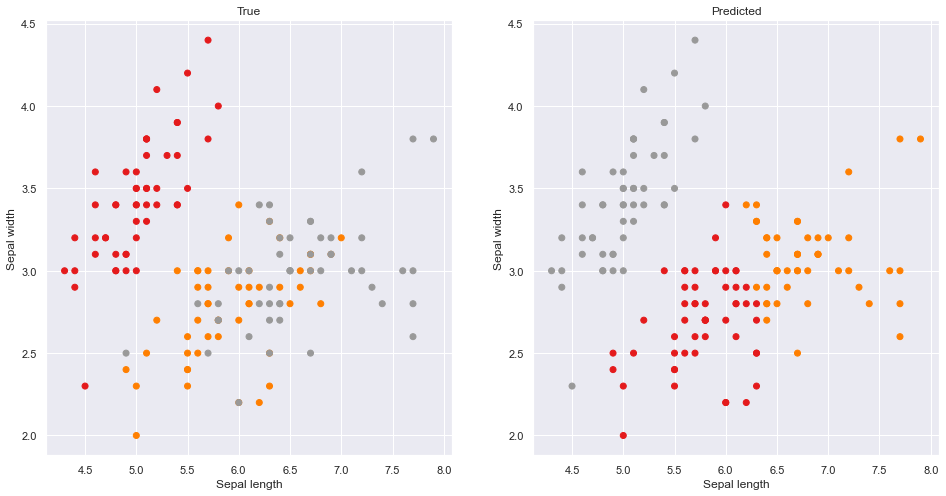

In [13]:
# Load data
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only use the first two features 
#                       (see dimensionality exercise).
y = iris.target       # the classification
# Range
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Fit KMeans
km = KMeans(n_clusters = 3, 
            random_state = 42)
km.fit(X)
# Plotting
#this will tell us to which cluster does the data observations belong.
y_pred = km.labels_
# Plot the identified clusters and compare with the answers
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap = 'Set1')
axes[1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap = 'Set1')
axes[0].set_xlabel('Sepal length')
axes[0].set_ylabel('Sepal width')
axes[1].set_xlabel('Sepal length')
axes[1].set_ylabel('Sepal width')
#axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
#axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('True')
axes[1].set_title('Predicted')

## Exercises

- Try the example above with too few and too many clusters
- Use ```verbose = True``` in ```Kmeans``` to see the convergence
- Use ```np.array([[0,0],[0,0],[0,0]])``` together with verbose to comment on the convergence
- Print the confusion matrix (no need to plot, however feel free!)
- Does increasing the dimensionality improve the prediction?

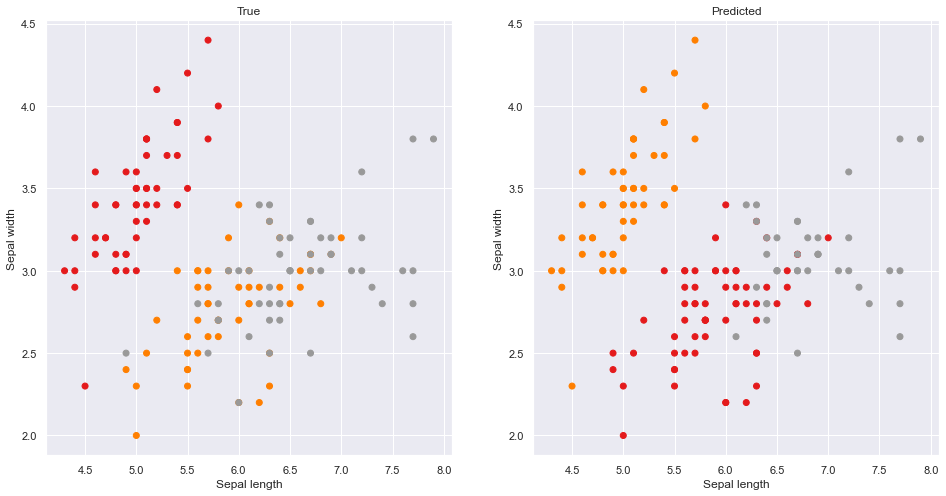

In [16]:
# Solution for 4D case
X = iris.data  # Now all features
#                       (see dimensionality exercise).
y = iris.target       # the classification

# Fit KMeans
km = KMeans(n_clusters = 3, 
            random_state = 42)
km.fit(X)
# Plotting
#this will tell us to which cluster does the data observations belong.
y_pred = km.labels_
# Print 2D projection
# Range
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
y_pred = km.labels_
# Plot the identified clusters and compare with the answers
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap = 'Set1')
axes[1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap = 'Set1')
axes[0].set_xlabel('Sepal length')
axes[0].set_ylabel('Sepal width')
axes[1].set_xlabel('Sepal length')
axes[1].set_ylabel('Sepal width')
#axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
#axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('True')
ret = axes[1].set_title('Predicted')

